<a href="https://colab.research.google.com/github/javier-jaime/Tool-Crib/blob/master/MTA/Shapley_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MTA Model with Shapley Value

Using the sample marketing dataset from [Kaggle](https://www.kaggle.com/datasets/kavitabhagwani/marketing-campaign), we used four variables:
- user_id
- date_served
- marketing_channel
-converted

Adapted from: https://bernard-mlab.com/

In [17]:
# import packages necessary libraries
import itertools
from pathlib import Path
from collections import defaultdict
from itertools import combinations, permutations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from google.colab import files

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
# Mount Google Drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Read dataset from CSV in Google Drive to Pandas Data Frame
data_raw = pd.read_csv('drive/MyDrive/Colab_Notebooks/Datasets/marketing.csv')
print(data_raw.shape)

(10037, 12)


In [20]:
# Extract the required columns
columns = ['user_id', 'date_served', 'marketing_channel', 'converted']
data = data_raw[columns].copy()
print(f"Data dimension: {data.shape}")

# Drop null values
data.dropna(axis=0, inplace=True)
print(f"Data dimension after dropping null values: {data.shape}")

# Recast conversion as binary
data['converted'] = data['converted'].astype('int')

# Convert date_served to datetime
data['date_served'] = pd.to_datetime(data['date_served'], format='%m/%d/%y', errors='coerce')

Data dimension: (10037, 4)
Data dimension after dropping null values: (10021, 4)


In [21]:
# Create a channel mix conversion table in 3 levels
data_lvl1 = data[['user_id', 'marketing_channel', 'converted']].sort_values(by=['user_id', 'marketing_channel'])
data_lvl2 = data_lvl1.groupby(['user_id'], as_index=False).agg({'marketing_channel': lambda x: ','.join(map(str,x.unique())),                                                               'converted':max})
data_lvl2.rename(columns={'marketing_channel':'marketing_channel_subset'}, inplace=True)
data_lvl3 = data_lvl2.groupby(['marketing_channel_subset'], as_index=False).agg(sum)

In [22]:
# Helper formulas for shapley values

def power_set(List):
    PS = [list(j) for i in range(len(List)) for j in itertools.combinations(List, i+1)]
    return PS

def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

def v_function(A,C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionnary containing the number of conversions that each subset of channels has yielded.
    '''
    subsets_of_A = subsets(A)
    worth_of_A=0
    for subset in subsets_of_A:
        if subset in C_values:
            worth_of_A += C_values[subset]
    return worth_of_A

def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return list(map(",".join,map(sorted,sub_channels)))

def calculate_shapley(df, channel_name, conv_name):
    '''
    This function returns the shapley values
            - df: A dataframe with the two columns: ['channel_subset', 'count'].
            The channel_subset column is the channel(s) associated with the conversion and the count is the sum of the conversions.
            - channel_name: A string that is the name of the channel column
            - conv_name: A string that is the name of the column with conversions
            **Make sure that that each value in channel_subset is in alphabetical order. Email,PPC and PPC,Email are the same
            in regards to this analysis and should be combined under Email,PPC.

    '''
    # Cast the subset into a dict, and get unique channels
    c_values = df.set_index(channel_name).to_dict()[conv_name]
    df['channels'] = df[channel_name].apply(lambda x: x if len(x.split(",")) == 1 else np.nan)
    channels = list(df['channels'].dropna().unique())

    v_values = {}
    for A in power_set(channels): #generate all possible channel combination
        v_values[','.join(sorted(A))] = v_function(A,c_values)
    n=len(channels) #no. of channels
    shapley_values = defaultdict(int)

    for channel in channels:
        for A in v_values.keys():
            if channel not in A.split(","):
                cardinal_A=len(A.split(","))
                A_with_channel = A.split(",")
                A_with_channel.append(channel)
                A_with_channel=",".join(sorted(A_with_channel))
                weight = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n)) # Weight = |S|!(n-|S|-1)!/n!
                contrib = (v_values[A_with_channel]-v_values[A]) # Marginal contribution = v(S U {i})-v(S)
                shapley_values[channel] += weight * contrib
        # Add the term corresponding to the empty set
        shapley_values[channel]+= v_values[channel]/n

    return shapley_values

In [23]:
# Calculate the Shapley value of the channel
shapley_dict = calculate_shapley(data_lvl3, 'marketing_channel_subset', 'converted')
shapley_result = pd.DataFrame(list(shapley_dict.items()), columns=['channel', 'shapley_value'])

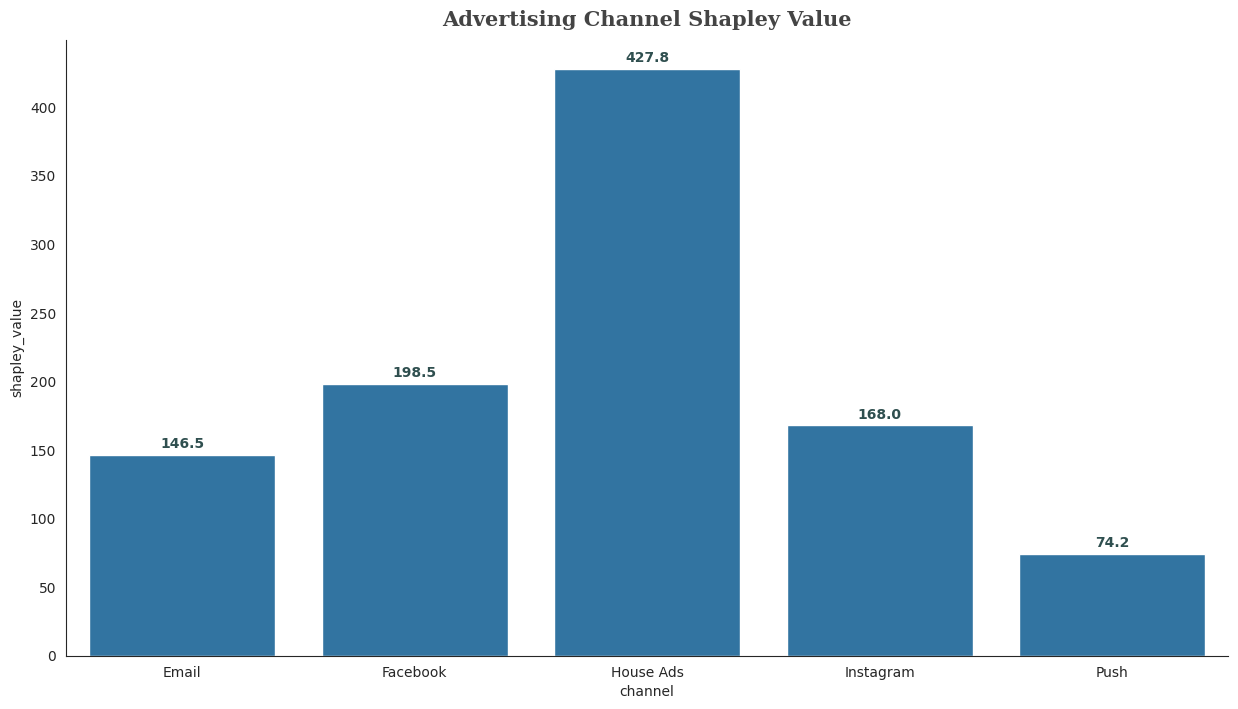

In [24]:
# Visualize the results
plt.subplots(figsize=(15,8))
s = sns.barplot(x='channel', y='shapley_value', data=shapley_result)
sns.despine(top=True, right=True)
for idx, row in shapley_result.iterrows():
    s.text(row.name, row.shapley_value +5, round(row.shapley_value,1), ha='center', color='darkslategray', fontweight='semibold')
plt.title("Advertising Channel Shapley Value",
          fontdict={'fontfamily': 'serif', 'fontsize': 15, 'fontweight': 'semibold', 'color':'#444444'},
          loc='center', pad=10)
plt.show()